In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"

In [2]:
!python build_results_dataframe.py

In [3]:
model_profile = pd.read_csv("model_profile.csv").set_index("model")
df = pd.read_csv("results.csv")
df.head()

,path,model,pretrain_dataset,downstream_dataset,epoch,total_epochs,name,gflops_total,samples_per_sec,samples_per_sec_per_gpu,global_batch_size,training_time_hours,gpus,total_steps,task,contrastive_loss,caption_loss,namespace,eval_type,gpu_hours,image_acc,text_acc,acc,acc1,acc5,mean_per_class_recall,image_retrieval_recall@5,text_retrieval_recall@5,name_epoch,samples_seen_scale_simple,samples_seen_scale,lr,warmup,model_simple,name_wo_model,namespace_model,model_simple_namespace,namespace_model_samples_seen_scale,name_wo_lr
0,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1/checkpoints/sugar_crepe_swap_att_epoch_2.pt_mammut_ViT-M-32_en_generative_image_caption_selection.json,mammut_ViT-M-32,sugar,sugar_crepe/swap_att,2,10,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1,28800000.0,1490.823667,372.705917,512.0,0.238496,4.0,2500.0,generative_image_caption_selection,0.0,5.2083,cap,log_likelihood,0.953984,1.0000,0.569069,0.569069,NaN,NaN,NaN,NaN,NaN,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw12,1.28M,1.28M,0.0015,1000,ViT-M-32,0.0015_1.28M_512.0_1000,mammut_ViT-M-32_cap,ViT-M-32_cap,mammut_ViT-M-32_cap_1.28M,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1
1,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1/checkpoints/winoground_epoch_10.pt_mammut_ViT-M-32_en_generative_image_caption_selection.json,mammut_ViT-M-32,winoground,winoground,10,10,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1,28800000.0,1490.823667,372.705917,512.0,0.238496,4.0,2500.0,generative_image_caption_selection,0.0,5.2083,cap,log_likelihood,0.953984,0.0675,0.025000,0.005000,NaN,NaN,NaN,NaN,NaN,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw110,1.28M,1.28M,0.0015,1000,ViT-M-32,0.0015_1.28M_512.0_1000,mammut_ViT-M-32_cap,ViT-M-32_cap,mammut_ViT-M-32_cap_1.28M,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1
2,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1/checkpoints/imagenet1k_epoch_1.pt_mammut_ViT-M-32_en_generative_zeroshot_classification.json,mammut_ViT-M-32,imagenet1k,imagenet1k,1,10,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1,28800000.0,1490.823667,372.705917,512.0,0.238496,4.0,2500.0,generative_zeroshot_classification,0.0,5.2083,cap,log_likelihood,0.953984,NaN,NaN,NaN,0.000791,0.005736,0.0008,NaN,NaN,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw11,1.28M,1.28M,0.0015,1000,ViT-M-32,0.0015_1.28M_512.0_1000,mammut_ViT-M-32_cap,ViT-M-32_cap,mammut_ViT-M-32_cap_1.28M,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1
3,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1/checkpoints/winoground_epoch_7.pt_mammut_ViT-M-32_en_generative_image_caption_selection.json,mammut_ViT-M-32,winoground,winoground,7,10,datacomp_s1.28M_bs_512_mammut_ViT-M-32_ep10_lr0.0015_b1_0.9_b2_0.95_wd0.2_w1000_gc1_n1_bs128_sigFalse_consw0_cw1,28800000.0,1490.823667,372.705917,512.0,0.238496,4.0,2500.0,generative_image_caption_selection,0.0,5.2083,cap,log_likelihood,0.953984,0.

In [4]:
df.columns

Index(['path', 'model', 'pretrain_dataset', 'downstream_dataset', 'epoch',
       'total_epochs', 'name', 'gflops_total', 'samples_per_sec',
       'samples_per_sec_per_gpu', 'global_batch_size', 'training_time_hours',
       'gpus', 'total_steps', 'task', 'contrastive_loss', 'caption_loss',
       'namespace', 'eval_type', 'gpu_hours', 'image_acc', 'text_acc', 'acc',
       'acc1', 'acc5', 'mean_per_class_recall', 'image_retrieval_recall@5',
       'text_retrieval_recall@5', 'name_epoch', 'samples_seen_scale_simple',
       'samples_seen_scale', 'lr', 'warmup', 'model_simple', 'name_wo_model',
       'namespace_model', 'model_simple_namespace',
       'namespace_model_samples_seen_scale', 'name_wo_lr'],
      dtype='object')

In [5]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))
print("Number of evaluations", len(df))

Number of unique models:  1499
Number of unique checkpoints:  25177
Number of downstream datasets 12
Number of evaluations 104983


<Axes: xlabel='model_s', ylabel='samples_per_sec_per_gpu'>

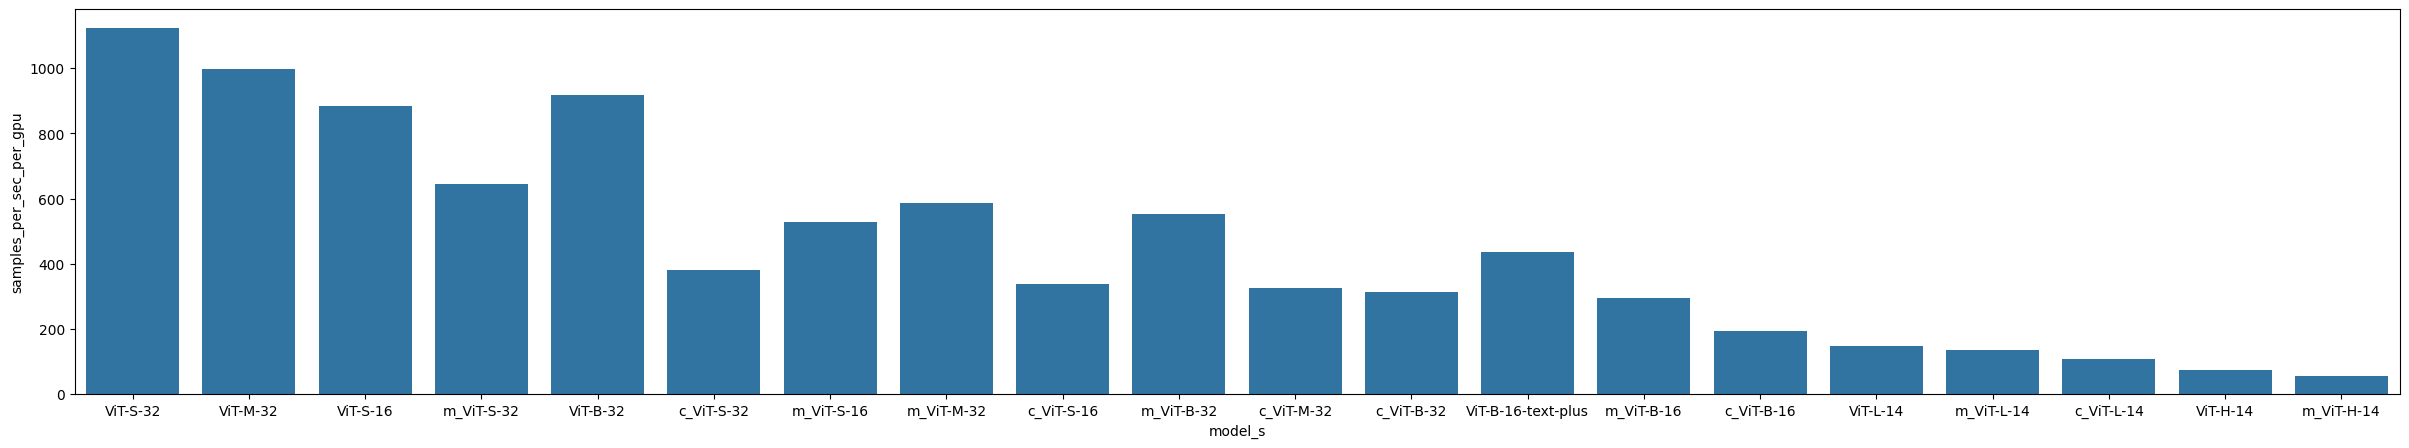

In [7]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))
archs = d.model_s.unique()
archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)
sns.barplot(x="model_s", y="samples_per_sec_per_gpu", data=d, order=archs, estimator=np.max)


In [7]:
d = df.copy()
df.groupby("model_simple_namespace").max("samples_per_sec_per_gpu").samples_per_sec_per_gpu.sort_values()

model_simple_namespace
ViT-H-14_mammut              55.467589
ViT-H-14_clip                74.115664
ViT-L-14_coca               107.178987
ViT-L-14_mammut             118.440348
ViT-L-14_cap                135.658584
ViT-L-14_clip               149.465855
ViT-B-16_coca               195.494934
ViT-B-16_mammut             252.852082
ViT-B-16_cap                294.591618
ViT-B-32_coca               313.512217
ViT-M-32_coca               327.108849
ViT-S-16_coca               338.673007
ViT-S-32_coca               380.128967
ViT-B-16-text-plus_clip     436.032583
ViT-S-16_mammut             480.001876
ViT-B-32_mammut             491.509814
ViT-M-32_mammut             520.326020
ViT-S-16_cap                528.224919
ViT-B-32_cap                552.763237
ViT-M-32_cap                586.268684
ViT-S-32_mammut             591.415351
ViT-S-32_cap                645.252519
ViT-S-16_clip               884.322854
ViT-B-32_clip               919.224325
ViT-M-32_clip               996.170031
Vi

In [7]:
model_profile.head()

,image_size,image_width,text_width,embed_dim,mparams,image_mparams,text_mparams,gflops,image_gflops,text_gflops
model,,,,,,,,,,
ViT-S-32-alt,224,384.0,256.0,256.0,43.22,22.59,20.63,3.56,2.29,1.27
ViT-S-32,224,384.0,384.0,384.0,63.09,22.64,40.44,5.66,2.29,3.38
ViT-M-32-alt,224,512.0,384.0,384.0,80.07,39.63,40.44,7.37,3.99,3.38
ViT-M-32,224,512.0,512.0,512.0,103.12,39.69,63.43,9.95,3.99,5.96
ViT-S-16-alt,224,384.0,256.0,256.0,42.40,21.76,20.63,10.47,9.20,1.27


In [8]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
80832,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
80808,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
80696,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
80831,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
54637,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [9]:
d = df
d = d[d.downstream_dataset=="imagenet1k"]
d = d[d.epoch==d.total_epochs]
d = d[d.samples_seen_scale_simple=="12.8B"]
d = d[d.model_simple=="ViT-L-14"]
d = d.sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace"]]
d

,acc1,name,namespace
80803,0.803380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
68971,0.802260,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
54609,0.801680,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
51063,0.801520,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
29380,0.800700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
79185,0.800280,datacomp_s12.8B_bs_360960_mammut_ViT-L-14_ep100_lr0.0035_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n320_bs282_sigFalse,mammut
57601,0.799060,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
59925,0.798600,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n176_bs128_sigFalse,mammut
54409,0.796100,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n176_bs128_sigFalse,mammut
60125,0.793400,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut


In [10]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
14069,0.857724,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
7117,0.853659,datacomp_s3B_bs_32768_mammut_ViT-L-14_ep48_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n32_bs256_sigFalse_consw0_cw1,cap,45
5865,0.853659,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
14053,0.853659,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,17
5641,0.849594,datacomp_s1.28B_bs_16384_mammut_ViT-B-16_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,17


In [11]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
28197,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
2354,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
2240,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20
28180,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
28095,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,93


<Axes: xlabel='epoch'>

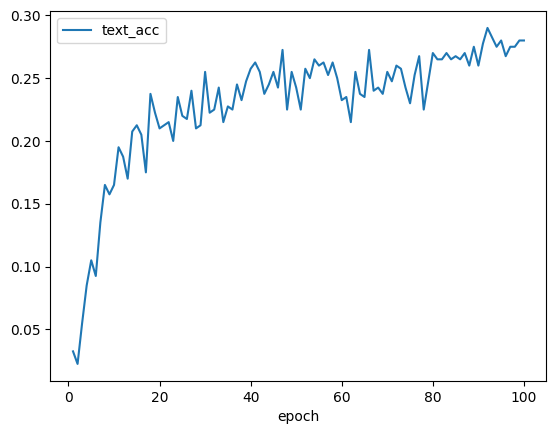

In [18]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"

ds = "winoground"
metric = "text_acc"
task = "generative_image_caption_selection"

#ds = "sugar_crepe/swap_obj"
#metric = "acc"
#task = "generative_image_caption_selection"

#ds = "imagenet1k"
#metric = "acc1"
#task = "zeroshot_classification"

d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
d.plot(x="epoch", y=metric)
#d[["epoch", metric]]

<Axes: xlabel='epoch', ylabel='text_acc'>

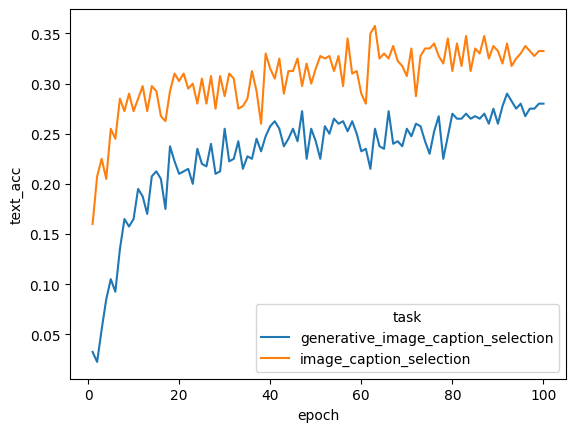

In [26]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "text_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)

<Axes: xlabel='epoch', ylabel='image_acc'>

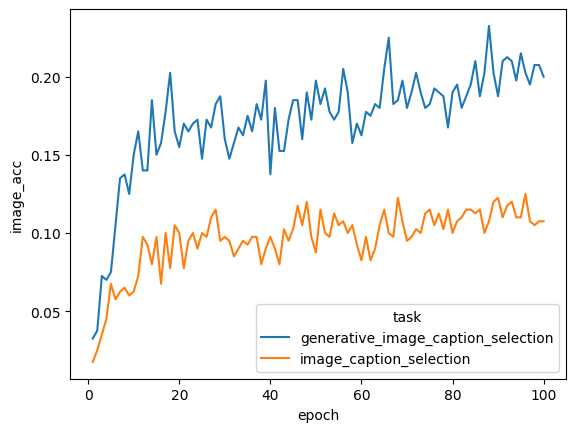

In [27]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)

In [6]:
d = df

#ds = 'sugar_crepe/swap_obj'
#metric = "acc"

#ds = "winoground"
#metric = "text_acc"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"
#metric = "text_retrieval_recall@5"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[~d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,60.4M,128M,300M,640M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,,
ViT-S-32_cap,0.002769,NaN,NaN,0.044304,NaN,NaN,0.163172,NaN,NaN,0.305973,NaN,NaN
ViT-S-32_clip,0.013040,0.03032,NaN,0.102080,0.18664,NaN,0.354020,0.43956,NaN,0.531180,0.55864,NaN
ViT-S-32_coca,0.015120,0.03340,NaN,0.112280,0.20104,NaN,0.357740,0.43960,NaN,NaN,NaN,NaN
ViT-S-32_mammut,0.014520,0.03340,0.06400,0.113840,0.20358,0.29304,0.372280,0.45214,0.50264,0.514200,0.56516,NaN
ViT-M-32_cap,0.003362,NaN,NaN,0.042326,NaN,NaN,0.204114,NaN,NaN,0.364715,NaN,NaN
ViT-M-32_clip,0.013960,0.03240,NaN,0.105040,0.20074,NaN,0.383020,0.47810,NaN,0.573040,0.60788,NaN
ViT-M-32_coca,0.015320,0.03114,NaN,0.119780,0.21860,NaN,0.388160,0.47972,NaN,NaN,NaN,NaN
ViT-M-32_mammut,0.013880,0.03344,0.06720,0.119640,0.22288,0.31810,0.403660,0.49076,0.55098,0.570700,0.61362,NaN
ViT-S-16_cap,0.005340,NaN,NaN,0.060324,NaN,NaN,0.204312,NaN,NaN,0.351859,NaN,NaN


     generative_zeroshot_classification  zeroshot_classification     delta  \
49                             0.688739                  0.80070  0.111961   
144                            0.429188                  0.65380  0.224612   
145                            0.398318                  0.63082  0.232502   
1                              0.404991                  0.61630  0.211309   
0                              0.401335                  0.61618  0.214845   

     gflops_total  
49   2.685952e+12  
144  8.398848e+10  
145  8.398848e+10  
1    3.499520e+10  
0    3.499520e+10  
208


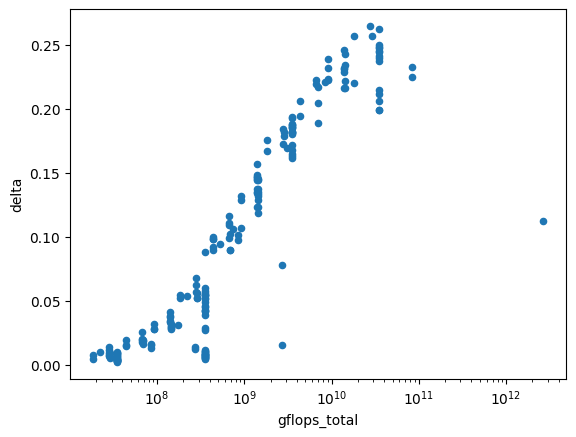

In [4]:
d = df.copy()

#ds = 'sugar_crepe/swap_obj'
#metric = "acc"
#task = "image_caption_selection"

#ds = "winoground"
#metric = "text_acc"
#task = "image_caption_selection"

ds = "imagenet1k"
metric = "acc1"
task = "zeroshot_classification"

gtask = "generative_" + task

d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
di = d[d.task==task]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
#d["delta"] = (d.generative_image_caption_selection - d.image_caption_selection).abs()
d["delta"] = (d[task] - d[gtask]).abs()
d = pd.merge(d, di, left_on='name_wo_task', right_on="name")
d = d.sort_values(by=task, ascending=False)#.head()
print(d[[gtask, task, "delta", "gflops_total"]].head())
print(len(d))
d.plot(x="gflops_total", y="delta", kind="scatter")
plt.xscale('log',base=10)


QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


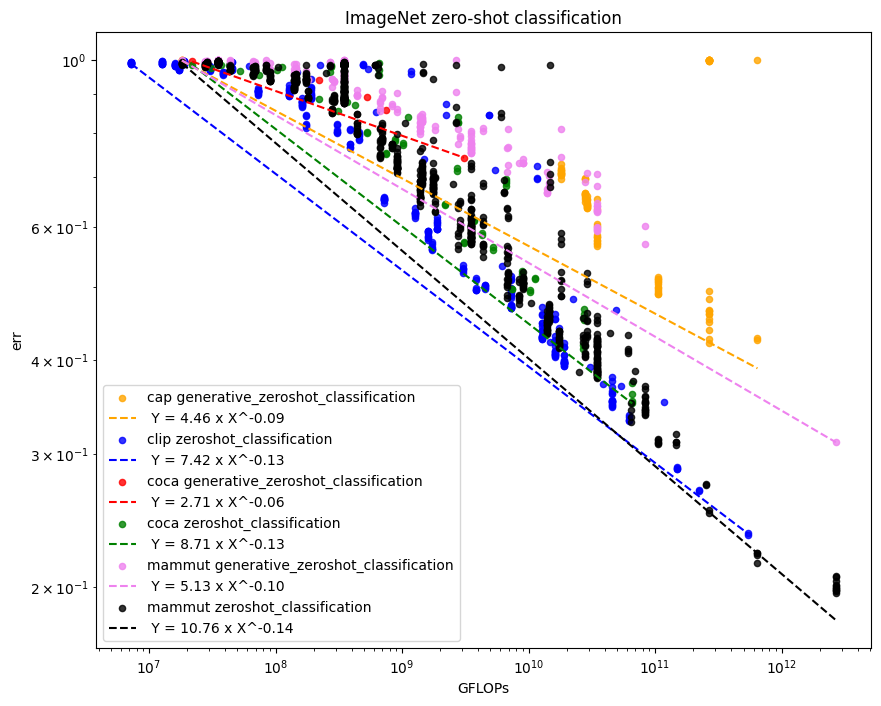

In [5]:
#ds = "sugar_crepe/swap_obj"
#metric = "acc"

#ds = "winoground"
#metric = "text_acc"

ds = "imagenet1k"
metric = "acc1"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"

D = df
D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = 1-(R[metric]).values


    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = X>0

    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

In [30]:
df.contrastive_loss.mean()

1.7612018629484236

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


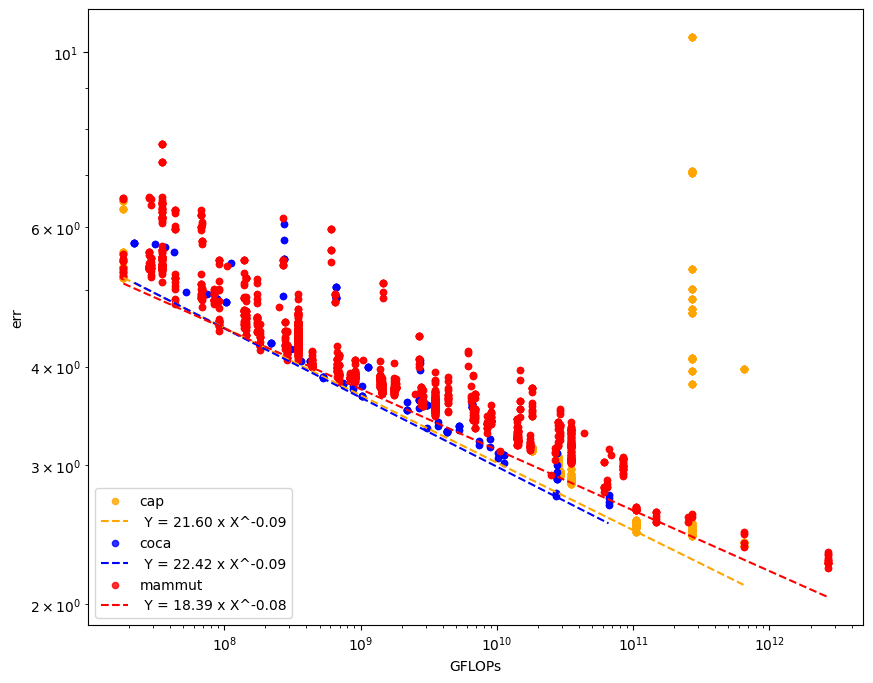

In [6]:
metric = "caption_loss"
D = df
D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()